In [2]:
import os
import sys
import math
import utils
import random
import layers
import dataset
import binvox_rw
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
#read params
with open("net.params") as f:
    batch_size=int(f.readline())
    epoch=int(f.readline())
    learning_rate=float(f.readline())

In [2]:
# place holders
x=tf.placeholder(tf.float32,[None,24,137,137,4]) 
y=tf.placeholder(tf.float32,[None,32,32,32])

# encoder network
cur_tensor=x
encoder_outputs=[cur_tensor]
print(cur_tensor.shape)
k_s = [3,3]
conv_filter_count = [96, 128, 256, 256, 256, 256]
for i in range(6): 
    ks=[7,7]if i is 0 else k_s  
    with tf.name_scope("encoding_block"): 
        cur_tensor=tf.map_fn(lambda a:tf.layers.conv2d(a,filters=conv_filter_count[i],padding='SAME',kernel_size= k_s,activation=None),cur_tensor)
        cur_tensor=tf.map_fn(lambda a:tf.layers.max_pooling2d(a,2,2),cur_tensor)
        cur_tensor=tf.map_fn(tf.nn.relu,cur_tensor)
        print(cur_tensor.shape)
        encoder_outputs.append(cur_tensor)

# flatten tensors
cur_tensor=tf.map_fn(tf.contrib.layers.flatten,cur_tensor)
cur_tensor=tf.map_fn(lambda a:tf.contrib.layers.fully_connected(a,1024,activation_fn=None),cur_tensor)
encoder_outputs.append(cur_tensor)
print(cur_tensor.shape)

(?, 24, 137, 137, 4)
(?, 24, 68, 68, 96)
(?, 24, 34, 34, 128)
(?, 24, 17, 17, 256)
(?, 24, 8, 8, 256)
(?, 24, 4, 4, 256)
(?, 24, 2, 2, 256)
(?, 24, 1024)


In [3]:
# recurrent module
with tf.name_scope("recurrent_module"): 
    
    N,n_x,n_h=4,1024,256
   
    recurrent_module=layers.GRU_R2N2(n_cells=N,n_input=n_x,n_hidden_state=n_h);

    # initial hidden state
    hidden_state_list=[]
    with open("net.params") as f:
        batch_size=int(f.readline())
        hidden_state= tf.zeros([1,4,4,4,256])
    
    # feed batches of seqeuences
    for t in range(24):
        fc_batch_t = cur_tensor[:,t,:]
        hidden_state_list.append(hidden_state)
        hidden_state = recurrent_module.call(fc_batch_t, hidden_state)
    print(hidden_state.shape)
cur_tensor=hidden_state

(?, 4, 4, 4, 256)


In [4]:
# decoding network
decoder_outputs=[cur_tensor]
cur_tensor=layers.unpool3D(cur_tensor)
print(cur_tensor.shape)
decoder_outputs.append(cur_tensor)

k_s = [3,3,3]
deconv_filter_count = [128, 128, 128, 64, 32, 2]
for i in range(2,4): 
    with tf.name_scope("decoding_block"):
        cur_tensor=tf.layers.conv3d(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
        cur_tensor=layers.unpool3D(cur_tensor)
        cur_tensor=tf.nn.relu(cur_tensor)
        print(cur_tensor.shape)
        decoder_outputs.append(cur_tensor)
            
for i in range(4,6): 
    with tf.name_scope("decoding_block_without_unpooling"):
        cur_tensor=tf.layers.conv3d(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
        cur_tensor=tf.nn.relu(cur_tensor)
        print(cur_tensor.shape)
        decoder_outputs.append(cur_tensor)

(?, 8, 8, 8, 256)
(?, 16, 16, 16, 128)
(?, 32, 32, 32, 64)
(?, 32, 32, 32, 32)
(?, 32, 32, 32, 2)


In [5]:
with tf.name_scope("cost"):
    #3d voxel-wise softmax
    y_hat=tf.nn.softmax(decoder_outputs[-1])
    prediction=tf.to_float(tf.argmax(y_hat,axis=4))
    p,q=y_hat[:,:,:,:,0],y_hat[:,:,:,:,1]
    cross_entropies=tf.reduce_sum(-tf.multiply(tf.log(p),y)-tf.multiply(tf.log(q),1-y),[1,2,3])
    accuracies=tf.reduce_sum(tf.to_float(tf.equal(y,prediction)),axis=[1,2,3])/tf.constant(32*32*32,dtype=tf.float32)
    mean_loss=tf.reduce_mean(cross_entropies)
    mean_accuracy=tf.reduce_mean(accuracies)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropies)

In [6]:
# output
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

# tensorboard/ vis tools
writer = tf.summary.FileWriter("./logs/")
writer.add_graph(sess.graph)

In [11]:
data_all=np.load("all_data.npy")  
label_all=np.load("all_labels.npy")
N=len(data_all)
print(data_all.shape)
print(label_all.shape)

(100, 24, 137, 137, 4)
(100, 32, 32, 32)


In [17]:
# setup training
root_train_dir = "train_dir"
cur_time = str(datetime.now().strftime('%Y|%m|%d %I:%M:%S %p'))
train_dir=os.path.join(root_train_dir,cur_time)
saver = tf.train.Saver()

# train network
print("starting training at {}".format(cur_time))
loss_session=[]
acc_session=[]
for e in range(epoch):
    perm=np.random.permutation(N)
    data_all=data_all[perm]
    label_all=label_all[perm]
    split_size=N/batch_size
    data_batchs=np.array_split(data_all,split_size)
    label_batchs=np.array_split(label_all,split_size)
    loss_epoch=[]
    acc_epoch=[]
    # print("starting epoch_{:03d}".format(e))
    epoch_dir="{}/epoch_{:03d}".format(train_dir,e)
    os.makedirs(epoch_dir)
    
    batch_number=0
    for data,label in zip(data_batchs,label_batchs):
        fd={x:data, y: label};
        batch_info=sess.run([mean_loss,mean_accuracy],feed_dict=fd)
        loss_batch=batch_info[0]
        acc_batch=batch_info[1]
        loss_epoch.append(loss_batch)
        acc_epoch.append(acc_batch)
        
        batch_number+=1
        if batch_number%50==0:
            print("epoch_{:03d}-batch_{:03d}: loss={}, acc={}".format(e,batch_number,batch_info[0],batch_info[1]))
            # record parameters and generate plots 
            fig = plt.figure()
            plt.plot(loss_epoch)
            plt.savefig("{}/{}_loss.png".format(epoch_dir,batch_number),bbox_inches='tight')
            plt.close()
            fig = plt.figure()
            plt.plot(acc_epoch)
            plt.savefig("{}/{}_acc.png".format(epoch_dir,batch_number),bbox_inches='tight')
            plt.close()
    print("saving checkpoint for epoch {}".format(e))
    saver.save(sess,"{}/model.ckpt".format(epoch_dir))   
    loss_session.append(loss_epoch)
    acc_session.append(acc_epoch)
    np.save("{}/losses".format(epoch_dir),np.array(loss_session))
    np.save("{}/accs".format(epoch_dir),np.array(acc_session))

starting training at 2018|01|10 11:46:00 AM
epoch_000-batch_000: loss=22509.5234375, acc=0.3348236083984375


KeyboardInterrupt: 

In [ ]:
# %matplotlib inline
# bat=3
# ind=5
# utils.imshow_multichannel(data_batchs[bat][ind,0])
# utils.imshow_voxel(label_batchs[bat][ind])

In [13]:
l=np.load("accs.npy")

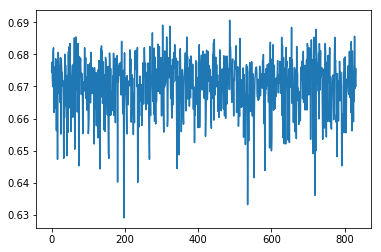

In [14]:
%matplotlib inline
plt.figure()
#flattened in row major form
plt.plot(l.flatten())